## extract VCSN daily data for the Hunuas ranges (Watercare application case )

In [1]:
# Paramaters 

### VARIABLE 

# var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean_N'
# var_name = 'SoilM'
# var_name = 'Wind'
var_name = 'Rad'


### CATCHMENT: `H` = HUNUA Ranges, `W` = `WAITAKERE` Ranges 

code = 'W'

In [2]:
%matplotlib inline

In [3]:
import sys 
import pathlib

In [4]:
sys.path.append('../../../utils')

In [5]:
from set_root_dir import set_root_dir

In [6]:
from matplotlib import pyplot as plt 
import proplot as plot 

In [7]:
import pandas as pd

In [8]:
import geopandas as gpd 

In [9]:
import xarray as xr
import salem

In [10]:
from cartopy import crs as ccrs

In [11]:
HOME = pathlib.Path.home() 

### reads the shapefile for the HUNUAS and the WAITAKERE basins (merged)

In [12]:
shapes = gpd.read_file('./HUNUAS_and_WAITAKERE.json')

### need to convert from lat/lon (WGS84, epsg 4326) to the New Zealand Grid Map (NZGD 1949 / EPSG 4272) to match the VCSN projection

In [13]:
shapes.crs

{'init': 'epsg:4326'}

In [14]:
shapes = shapes.to_crs(epsg=4272)

In [15]:
shapes.crs

{'init': 'epsg:4272', 'no_defs': True}

In [16]:
shapes

,GIS_ID,FAC_CODE,GRP,GRP_CODE,LAND_AREA,MSLINK,CREATEBY,CREATEDATE,MODIFYBY,MODIFYDATE,MODIFYREF,catchment,geometry
0,23630,SDCOS,SD,None,21478632.56,0,wsl,2006-04-13,wsl,2006-04-13,CameronKng,H,"POLYGON ((175.17766 -37.09304, 175.17856 -37.0..."
1,23639,None,SD,None,575982.03,0,wsl,2006-04-13,wsl,2006-04-13,CameronKng,W,"POLYGON ((174.58120 -36.97652, 174.58120 -36.9..."


### set the index to be the catchment (`W` = Waitakere, `H` = Hunuas)

In [17]:
shapes = shapes.set_index('catchment')

In [18]:
shapes

,GIS_ID,FAC_CODE,GRP,GRP_CODE,LAND_AREA,MSLINK,CREATEBY,CREATEDATE,MODIFYBY,MODIFYDATE,MODIFYREF,geometry
catchment,,,,,,,,,,,,
H,23630,SDCOS,SD,None,21478632.56,0,wsl,2006-04-13,wsl,2006-04-13,CameronKng,"POLYGON ((175.17766 -37.09304, 175.17856 -37.0..."
W,23639,None,SD,None,575982.03,0,wsl,2006-04-13,wsl,2006-04-13,CameronKng,"POLYGON ((174.58120 -36.97652, 174.58120 -36.9..."


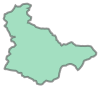

In [19]:
shapes.loc['W','geometry']

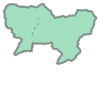

In [20]:
shapes.loc['H','geometry']

### Reads in the daily VCSN precipitation (Rain_bc = Bias Corrected Rainfall) 

In [21]:
dpath = HOME / 'operational/VCSN/data/NC/DAILY/' / var_name.upper()

In [22]:
lfiles_vcsn = list(dpath.glob("*.nc"))

In [23]:
lfiles_vcsn.sort()

In [24]:
len(lfiles_vcsn)

492

In [25]:
lfiles_vcsn[0]

PosixPath('/home/nicolasf/operational/VCSN/data/NC/DAILY/RAD/VCSN_gridded_daily_Rad_1979-01.nc')

In [26]:
lfiles_vcsn[-1]

PosixPath('/home/nicolasf/operational/VCSN/data/NC/DAILY/RAD/VCSN_gridded_daily_Rad_2019-12.nc')

### select the catchment here 

In [27]:
if code == 'W': 
    catch_name = 'Waitakere'
elif code == 'H': 
    catch_name = 'Hunua'

In [28]:
shape = shapes.loc[[code],:]

### this part reads the last file in the VCSN, in order to illustrate the intersection between VCSN grid and the catchment(s) geometry

In [29]:
fname = lfiles_vcsn[-1]

In [30]:
dset = salem.open_xr_dataset(fname)

### the dataset has the `pyproj_srs` attribute set to `epsg:4272`

In [31]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 31)
Coordinates:
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * time     (time) datetime64[ns] 2019-12-01 2019-12-02 ... 2019-12-31
Data variables:
    Rad      (time, lat, lon) float64 ...
    agent    (lat, lon) float32 ...
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### selects the subset (region enclosing)

In [32]:
catchment = dset.salem.subset(shape=shape, margin=2)

### read the NZ shapefile (country coastline)

In [33]:
nz = gpd.read_file(set_root_dir(root='local') / 'shapefiles' / 'NZ' / 'NZ.json') 

In [34]:
nz.crs

{'init': 'epsg:4326'}

### also need to reproject this one 

In [35]:
nz = nz.to_crs(epsg=4272)

### now extract the indices themselves 

### including intersections 

In [36]:
sub_intersect = catchment.salem.roi(shape=shape, all_touched=True)

### not including intersection 

In [37]:
sub_in = catchment.salem.roi(shape=shape, all_touched=False)

### illustration plot 

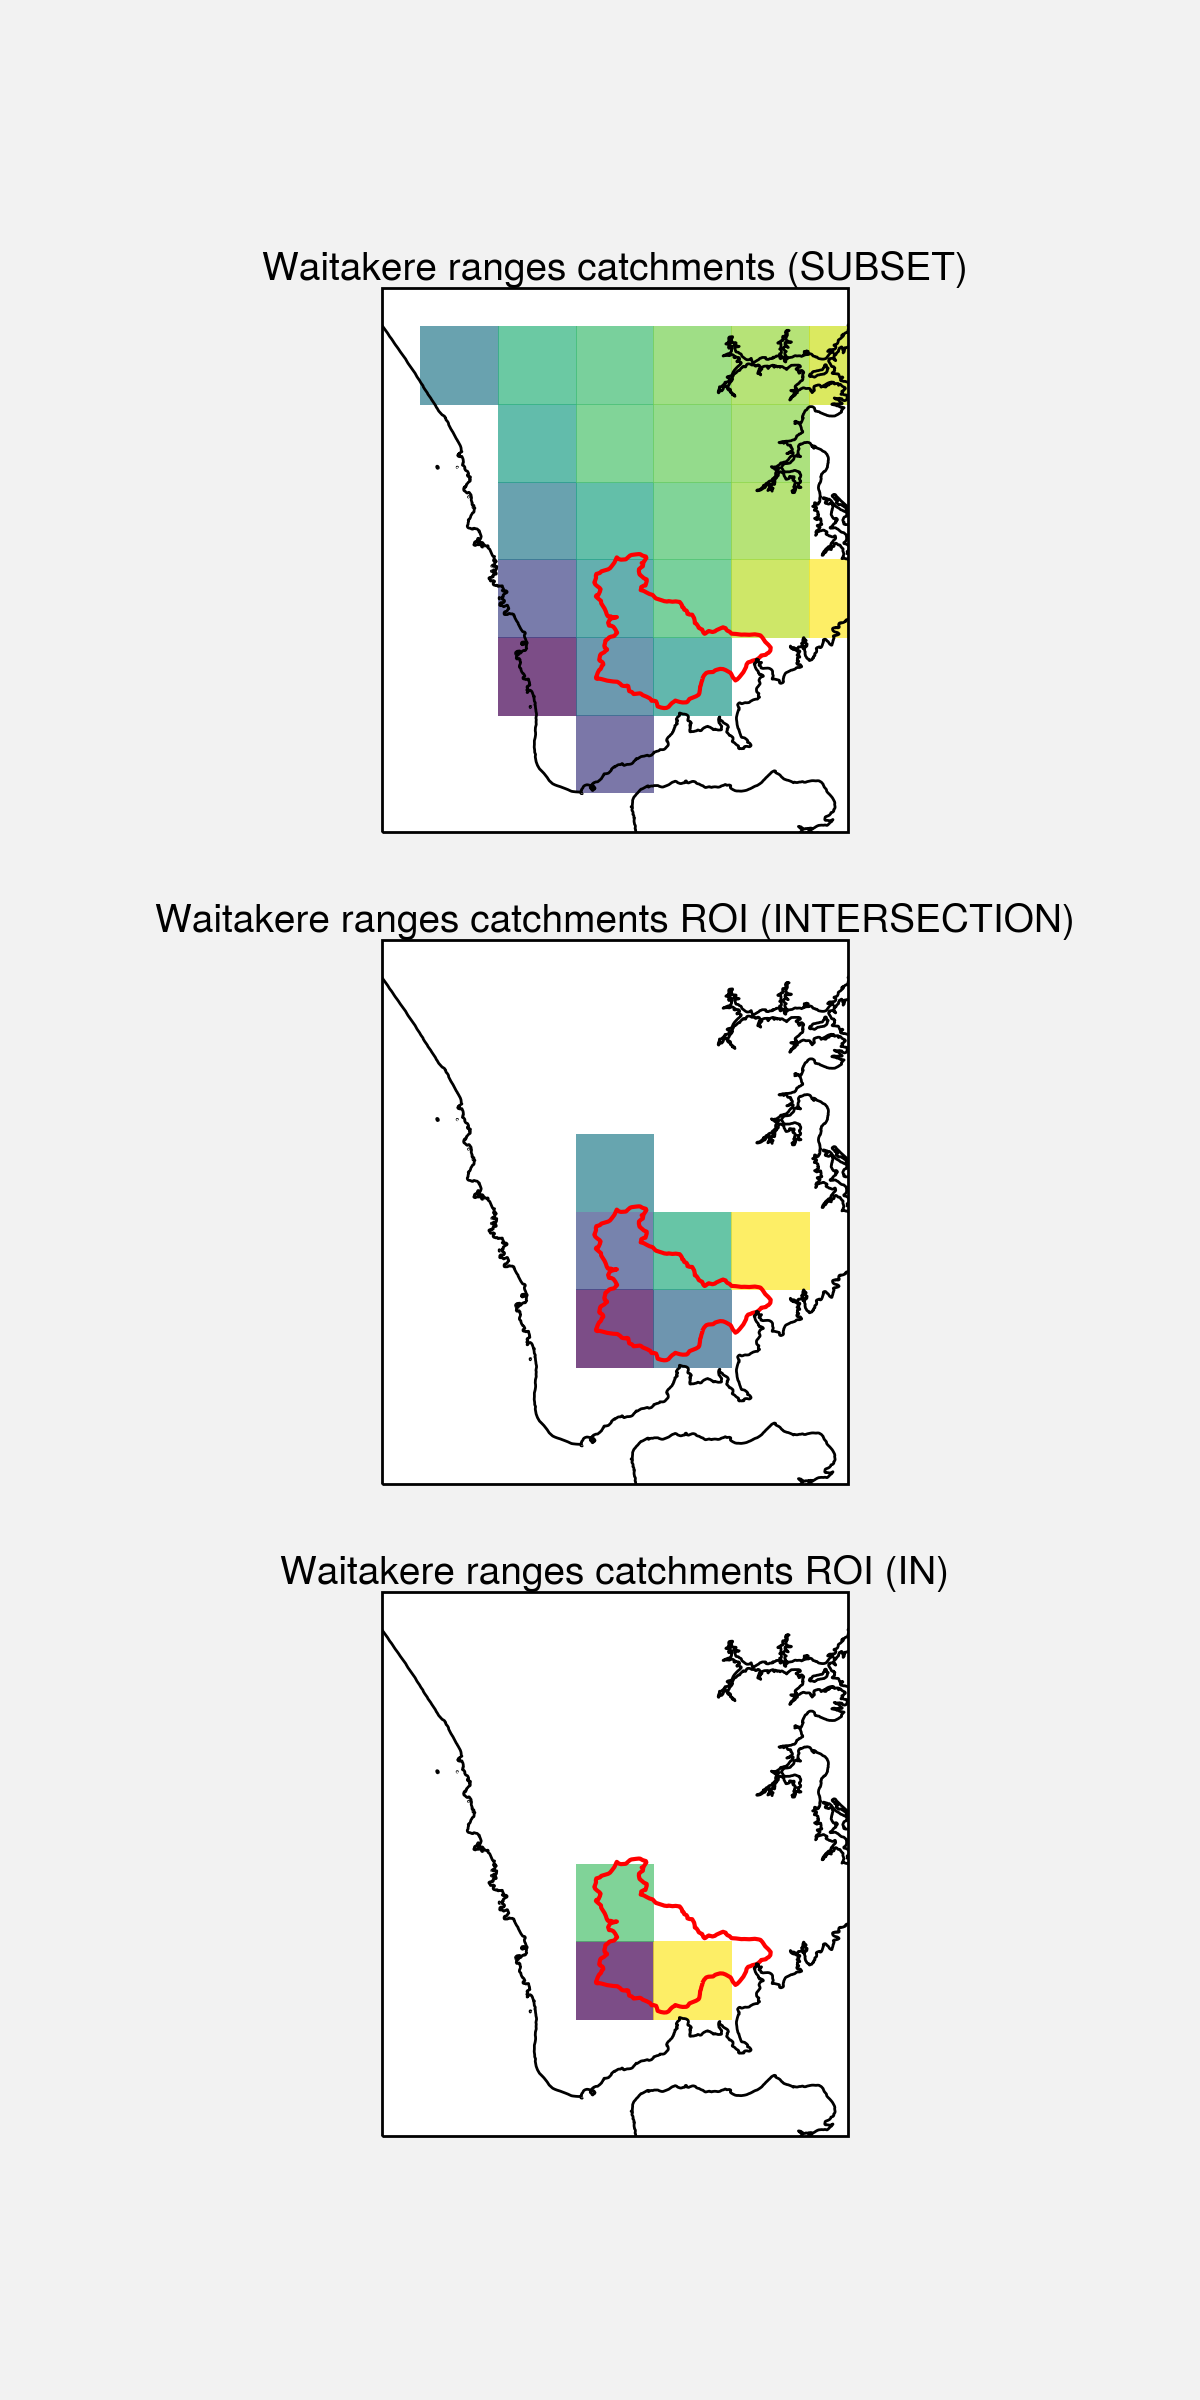

In [38]:
f, axes = plt.subplots(nrows=3, figsize=(6,12), subplot_kw={'projection':ccrs.PlateCarree()})

ax = axes[0]

catchment[var_name][0,:,:].plot(ax=ax, add_colorbar=False, cmap=plt.cm.viridis, alpha=0.7)
shape.boundary.plot(ax=ax, lw=1.5, color='r')
nz.boundary.plot(ax=ax, lw=1, color='k')
# ax.coastlines(resolution='10m')
ax.set_extent([catchment.lon.data.min()-0.05, catchment.lon.data.max(), catchment.lat.data.min()-0.05, catchment.lat.data.max()+0.05]) 
ax.set_title(f'{catch_name} ranges catchments (SUBSET)', fontsize=14)

ax = axes[1]

sub_intersect[var_name][0,:,:].plot(ax=ax, add_colorbar=False, cmap=plt.cm.viridis, alpha=0.7)
shape.boundary.plot(ax=ax, lw=1.5, color='r')
nz.boundary.plot(ax=ax, lw=1, color='k')
# ax.coastlines(resolution='10m')
ax.set_extent([catchment.lon.data.min()-0.05, catchment.lon.data.max(), catchment.lat.data.min()-0.05, catchment.lat.data.max()+0.05]) 
ax.set_title(f'{catch_name} ranges catchments ROI (INTERSECTION)', fontsize=14)

ax = axes[2]

sub_in[var_name][0,:,:].plot(ax=ax, add_colorbar=False, cmap=plt.cm.viridis, alpha=0.7)
shape.boundary.plot(ax=ax, lw=1.5, color='r')
ax.plot(175.125, -37.075, 'r*', transform=ccrs.PlateCarree())
nz.boundary.plot(ax=ax, lw=1, color='k')
# ax.coastlines(resolution='10m')
ax.set_extent([catchment.lon.data.min()-0.05, catchment.lon.data.max(), catchment.lat.data.min()-0.05, catchment.lat.data.max()+0.05]) 
ax.set_title(f'{catch_name} ranges catchments ROI (IN)', fontsize=14)


f.savefig(f'./{catch_name}_ranges_merged_catchments.png', dpi=200, bbox_inches='tight')

In [39]:
# sub_in.stack(z=('lat','lon')).dropna(dim='z').lat.data

In [40]:
# sub_in.stack(z=('lat','lon')).dropna(dim='z').lon.data

### now loops over all the files, and calculates the cumulative daily precipitation indices, either `in` or `intersect` mode 

In [41]:
df_intersect = []
df_in = []

for fname in lfiles_vcsn: 
     
    dset = salem.open_xr_dataset(fname)
    
    catchment = dset.salem.subset(shape=shape, margin=2)
    
    sub_intersect = catchment.salem.roi(shape=shape, all_touched=True)
    
    sub_in = catchment.salem.roi(shape=shape, all_touched=False)
    
    if var_name == 'Rain_bc': 
    
        df_intersect.append(sub_intersect.sum(dim=['lat','lon'])[var_name])
    
    else: 
        
        df_intersect.append(sub_intersect.mean(dim=['lat','lon'])[var_name])
        
    df_in.append(sub_in.sum(dim=['lat','lon'])[var_name])
    
    dset.close() 
    
    catchment.close()

### concatenate over the time dimension 

In [42]:
df_in = xr.concat(df_in, dim='time')

In [43]:
df_intersect = xr.concat(df_intersect, dim='time')

### casts into a pandas dataframe

In [44]:
df_in = df_in.to_dataframe()

In [45]:
df_intersect = df_intersect.to_dataframe()

### rename columns 

In [46]:
df_in.columns = ['IN']

In [47]:
df_intersect.columns = ['INTERSECT']

### concatenate the dataframes along the columns 

In [48]:
df = pd.concat([df_intersect, df_in], axis=1)

In [49]:
df.head()

,INTERSECT,IN
time,,
1979-01-01,23.783333,69.7
1979-01-02,33.183333,98.3
1979-01-03,24.600000,72.3
1979-01-04,26.150000,78.0
1979-01-05,30.683333,91.5


### correlation 

In [50]:
df.corr()

,INTERSECT,IN
INTERSECT,1.000000,0.999573
IN,0.999573,1.000000


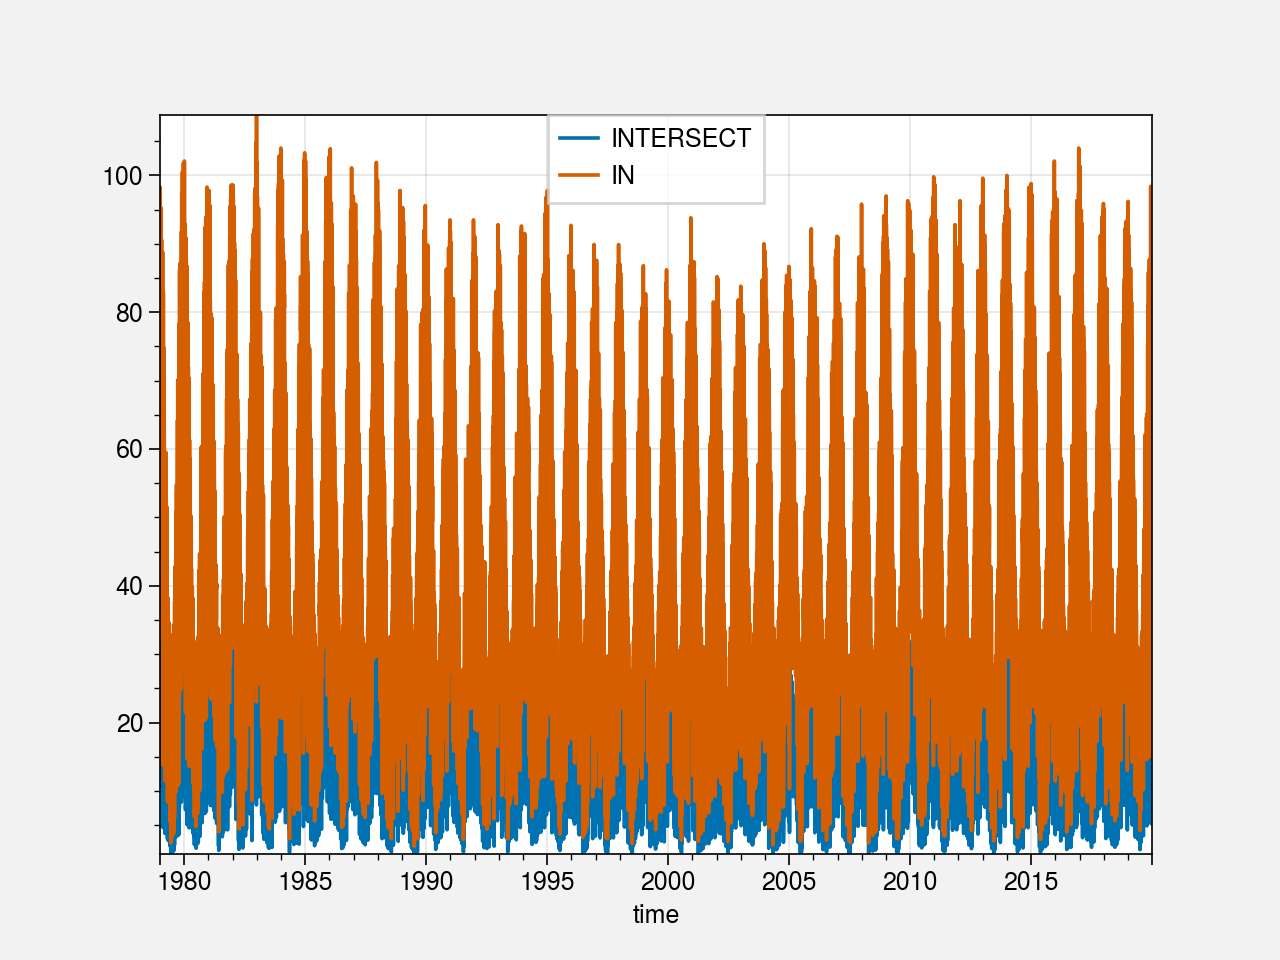

In [51]:
df.plot()

### calculates the monthly average from the daily data 

In [52]:
df_m = df.resample('1M').mean()

### calculates the monthly anomalies

In [53]:
def demean(x): 
    return x - x.loc['1981':'2010'].mean()

In [54]:
anoms_df = df_m.groupby(df_m.index.month).apply(demean)

### correlation between the monthly anomalies 

In [55]:
anoms_df.corr()

,INTERSECT,IN
INTERSECT,1.000000,0.997347
IN,0.997347,1.000000


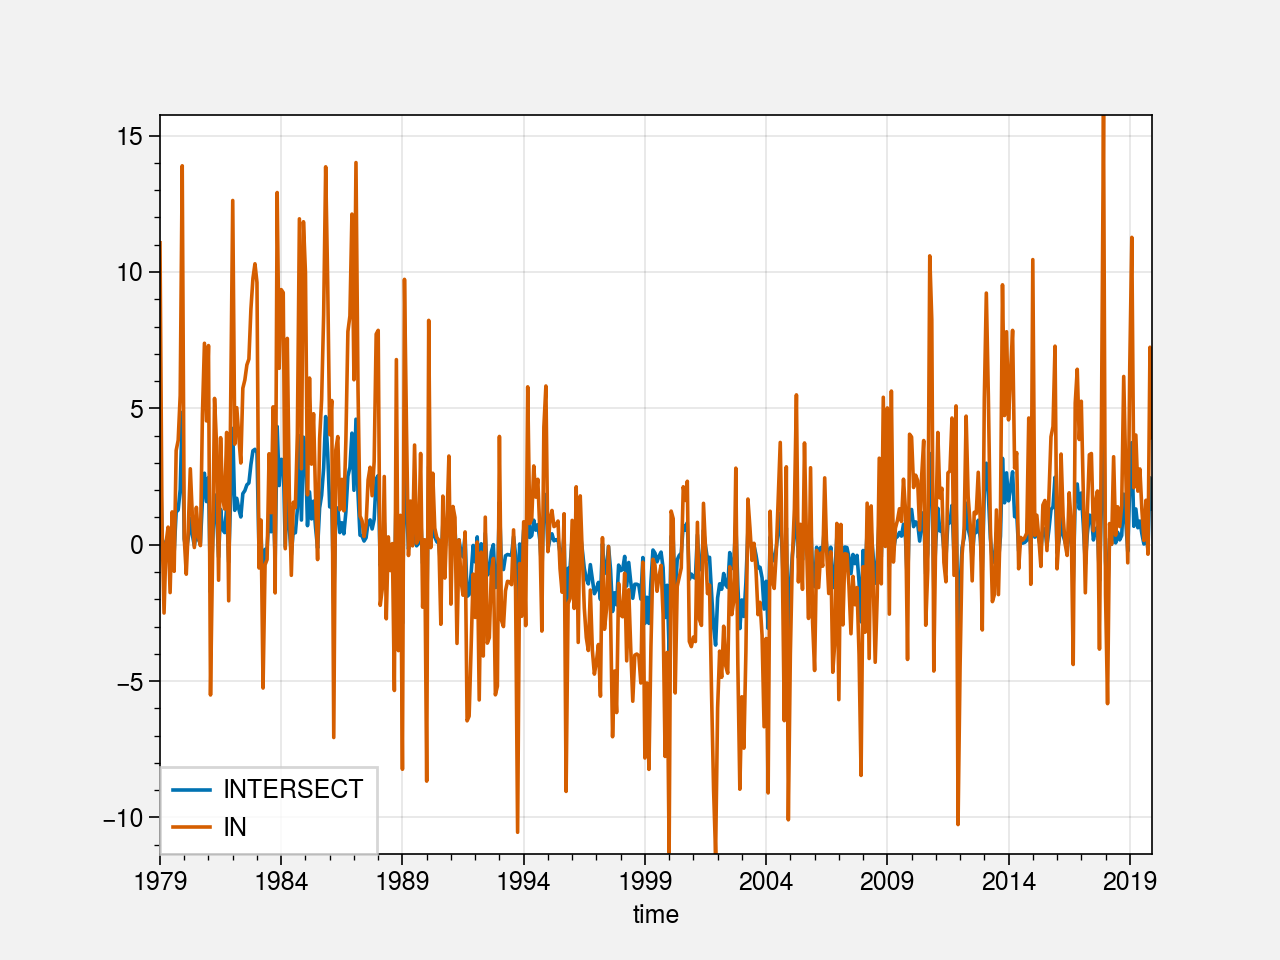

In [56]:
anoms_df.plot()

### saves to disk 

In [57]:
df.to_csv(f'./{catch_name}_ranges_{var_name}_indices_daily.csv')

In [58]:
df_m.to_csv(f'./{catch_name}_ranges_{var_name}_indices_monthly.csv')

In [59]:
anoms_df.to_csv(f'./{catch_name}_ranges_{var_name}_indices_monthly_anoms.csv')

In [60]:
print(f"======================================================================\nPROCESSING DONE FOR {catch_name.upper()} CATCHMENT")

PROCESSING DONE FOR WAITAKERE CATCHMENT


In [61]:
anoms_df

,INTERSECT,IN
time,,
1979-01-31,3.798315,11.070430
1979-02-28,0.335877,0.669585
1979-03-31,-0.863011,-2.504409
1979-04-30,0.132981,0.061667
1979-05-31,0.232258,0.645269
...,...,...
2019-08-31,0.025573,0.157312
2019-09-30,0.485037,1.629444
2019-10-31,-0.192294,-0.347312


In [62]:
# ### Now read the Waitakere time-series and compared to the Hunuas catchment just calculated 

# waitak = pd.read_csv('./Waitakere_ranges_indices_monthly_anoms.csv', index_col=0, parse_dates=True)

# waitak.columns = ['W_' + x for x in waitak.columns]

# hunua = anoms_df

# hunua.columns = ['H_' + x for x in hunua.columns]

# df_all = pd.concat([waitak, hunua], axis=1)

# df_all.corr()

# df_all.loc[:,['W_INTERSECT','H_INTERSECT']].corr()

# df_all.loc[:,['W_IN','H_IN']].plot()